Dependency:
!pip install wget

In [1]:
#import Library

import json
import wget
import os
import pandas as pd
import re
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from random import random
import zipfile
from sklearn.metrics import f1_score
import scipy.io
import time
import _pickle as cp
import datetime
import matplotlib.pyplot as plt

Some thought:
    - OPPORTUNITY Dataset Norm
    - OPPORTUNITY slide window training data generation

In [2]:
#MASTER CONTROL PANEL

#Create/ update cfg file - Select "True" if there is a need to update cfg Json file
cfg_update_is_required = True
#cfg_update_is_required = False

#Download Dataset - Select "True" if there is a need to download Dataset into Project folder
Dataset_download_is_required = True
#Dataset_download_is_required = False

#Select scope of the script to run
#Select "True" if OPPORTUNITY DATASET related Script is required
OPPORTUNITY_DATASET_related_Script_is_required = True
OPPORTUNITY_DATASET_related_Script_is_required = False

#Select "True" if SKODA DATASET related Script is required
SKODA_DATASET_related_Script_is_required = True
#SKODA_DATASET_related_Script_is_required = False

#Auto select device(cpu/ gpu) to run
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Have fun!")
else:
    device = torch.device("cpu")
    print("GPU is not available, CPU will be used...")

#Select Training DATASET
#Training_DATASET = 'OPPORTUNITY - 5 classes'
#Training_DATASET = 'OPPORTUNITY - 18 classes'
Training_DATASET = 'SKODA'


#Select Data Preprocessing approach for OPPORTUNITY DATASET
#OPPORTUNITY_DATASET_Proprocessing_approach = "Hongxu"
OPPORTUNITY_DATASET_Proprocessing_approach = "Paper"


GPU is available. Have fun!


In [3]:
#Create/ update cfg file - Run this if there is a need to update cfg Json file

if cfg_update_is_required == True:
    cfg = {}
    cfg['OPPORTUNITY_DATASET'] = {}
    cfg['OPPORTUNITY_DATASET']['Download_URL'] = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00226/OpportunityUCIDataset.zip'
    cfg['OPPORTUNITY_DATASET']['Download_Destination'] = 'Dataset/OpportunityUCIDataset'
    cfg['OPPORTUNITY_DATASET']['dataset_folder'] = 'Dataset/OpportunityUCIDataset/OpportunityUCIDataset/dataset'
    cfg['OPPORTUNITY_DATASET']['Normalization_parameter'] = 'Dataset/OPPORTUNITY_norm_parameter.csv'
    
    cfg['SKODA_DATASET'] = {}
    cfg['SKODA_DATASET']['Download_URL'] = 'http://har-dataset.org/lib/exe/fetch.php?media=wiki:dataset:skodaminicp:skodaminicp_2015_08.zip'
    cfg['SKODA_DATASET']['Download_Destination'] = 'Dataset/SKODA_DATASET'
    cfg['SKODA_DATASET']['dataset_path'] = 'Dataset/SKODA_DATASET/SkodaMiniCP_2015_08/right_classall_clean.mat'
    
    with open('cfg.json', 'w') as outfile:
        json.dump(cfg, outfile)
        
        
        
        
    
SILDE_WINDOW = 24
SILDE_WINDOW_STEP = 12

#to be automated
SKODA_Classification_weight = [0.386610555,
                                1.024348618,
                                0.874884602,
                                0.909393939,
                                1.26013017,
                                2.056418456,
                                2.188381138,
                                1.18103109,
                                1.079755337,
                                0.92690209,
                                1.650109971,]


NORM_MAX_THRESHOLDS = [3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,
                       3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,
                       3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,
                       3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,
                       3000,   3000,   3000,   10000,  10000,  10000,  1500,   1500,   1500,
                       3000,   3000,   3000,   10000,  10000,  10000,  1500,   1500,   1500,
                       3000,   3000,   3000,   10000,  10000,  10000,  1500,   1500,   1500,
                       3000,   3000,   3000,   10000,  10000,  10000,  1500,   1500,   1500,
                       3000,   3000,   3000,   10000,  10000,  10000,  1500,   1500,   1500,
                       250,    25,     200,    5000,   5000,   5000,   5000,   5000,   5000,
                       10000,  10000,  10000,  10000,  10000,  10000,  250,    250,    25,
                       200,    5000,   5000,   5000,   5000,   5000,   5000,   10000,  10000,
                       10000,  10000,  10000,  10000,  250, ]

NORM_MIN_THRESHOLDS = [-3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,
                       -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,
                       -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,
                       -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,
                       -3000,  -3000,  -3000,  -10000, -10000, -10000, -1000,  -1000,  -1000,
                       -3000,  -3000,  -3000,  -10000, -10000, -10000, -1000,  -1000,  -1000,
                       -3000,  -3000,  -3000,  -10000, -10000, -10000, -1000,  -1000,  -1000,
                       -3000,  -3000,  -3000,  -10000, -10000, -10000, -1000,  -1000,  -1000,
                       -3000,  -3000,  -3000,  -10000, -10000, -10000, -1000,  -1000,  -1000,
                       -250,   -100,   -200,   -5000,  -5000,  -5000,  -5000,  -5000,  -5000,
                       -10000, -10000, -10000, -10000, -10000, -10000, -250,   -250,   -100,
                       -200,   -5000,  -5000,  -5000,  -5000,  -5000,  -5000,  -10000, -10000,
                       -10000, -10000, -10000, -10000, -250, ]

In [4]:
#load configuration parameter from Json file into a dict
def import_cfg_file(cfg_file_path):
    with open(cfg_file_path) as json_file:
        cfg = json.load(json_file)
    return cfg

#Download dataset from given URL into local folder and unzip
def download_dataset(Source_URL, Destination):
    if not os.path.isfile(Destination + '.zip'):
        wget.download(Source_URL, Destination + '.zip')
    with zipfile.ZipFile(Destination + '.zip', 'r') as zip_ref:
        zip_ref.extractall(Destination)
    #os.remove(Destination + '.zip')
    print(' --- Dataset has been successfully downloaded into: ' + Destination)
    return 0

#Load OPPORTUNITY multi data files (DAT format), based on given file list
#convert loaded data into pandas df, assign column names to df
#replace NaN into 0.0
def OPPORTUNITY_Data_Loader(OPPORTUNITY_DATASET_FILE_LIST, OPPORTUNITY_DATASET_column_names):
    df_OPPORTUNITY_DATASET_All = ''
    for file_name in OPPORTUNITY_DATASET_FILE_LIST:
        if file_name.endswith(".dat"):
            df_OPPORTUNITY_DATASET_current = pd.read_csv(OPPORTUNITY_DATASET_dataset_folder + '/' + file_name, sep = ' ', header = None)
            df_OPPORTUNITY_DATASET_current.columns = OPPORTUNITY_DATASET_column_names
            df_OPPORTUNITY_DATASET_current = df_OPPORTUNITY_DATASET_current.interpolate()
            df_OPPORTUNITY_DATASET_current.replace(np.nan, 0.0, inplace=True)
            df_OPPORTUNITY_DATASET_current['file_name'] = file_name
            if type(df_OPPORTUNITY_DATASET_All) != pd.core.frame.DataFrame:
                df_OPPORTUNITY_DATASET_All = df_OPPORTUNITY_DATASET_current
            else:
                df_OPPORTUNITY_DATASET_All = pd.concat([df_OPPORTUNITY_DATASET_All, df_OPPORTUNITY_DATASET_current])
    return df_OPPORTUNITY_DATASET_All

#Using raw data to generate training data based on slide window apprach
def data_generator(ARRAY_OPPORTUNITY_DATASET_x, ARRAY_OPPORTUNITY_DATASET_y, SILDE_WINDOW, SILDE_WINDOW_STEP):
    ARRAY_OPPORTUNITY_DATASET_x = torch.tensor(ARRAY_OPPORTUNITY_DATASET_x).float()
    ARRAY_OPPORTUNITY_DATASET_y = torch.tensor(ARRAY_OPPORTUNITY_DATASET_y)
    #print(type(ARRAY_OPPORTUNITY_DATASET_x))
    array_len = len(ARRAY_OPPORTUNITY_DATASET_x)
    shape_0 = int(array_len / SILDE_WINDOW)
    shape_1 = SILDE_WINDOW
    shape_2 = len(ARRAY_OPPORTUNITY_DATASET_x[0])
    input_tensor = torch.reshape(ARRAY_OPPORTUNITY_DATASET_x[0: shape_0 * SILDE_WINDOW], (shape_0, shape_1, shape_2))
    #print(type(input_tensor))
    output_tensor = torch.reshape(ARRAY_OPPORTUNITY_DATASET_y[0: shape_0 * SILDE_WINDOW], (shape_0, shape_1))[:,-1]

    

    ARRAY_OPPORTUNITY_DATASET_x = ARRAY_OPPORTUNITY_DATASET_x[SILDE_WINDOW_STEP: ]
    array_len = len(ARRAY_OPPORTUNITY_DATASET_x)
    shape_0 = int(array_len / SILDE_WINDOW)
    shape_1 = SILDE_WINDOW
    shape_2 = len(ARRAY_OPPORTUNITY_DATASET_x[0])
    input_tensor_part_2 = torch.reshape(ARRAY_OPPORTUNITY_DATASET_x[0: shape_0 * SILDE_WINDOW], (shape_0, shape_1, shape_2))
    input_tensor = torch.cat((input_tensor, input_tensor_part_2), 0)
    
    ARRAY_OPPORTUNITY_DATASET_y = ARRAY_OPPORTUNITY_DATASET_y[SILDE_WINDOW_STEP: ]
    output_tensor_part_2 = torch.reshape(ARRAY_OPPORTUNITY_DATASET_y[0: shape_0 * SILDE_WINDOW], (shape_0, shape_1))[:,-1]
    output_tensor = torch.cat((output_tensor, output_tensor_part_2), 0)
    
    return input_tensor, output_tensor

#Export Tensor into csv file
def tensor_to_csv(tensor_name, file_name):
    x_np = tensor_name.cpu().detach().numpy()
    x_df = pd.DataFrame(x_np)
    x_df.to_csv('export/' + file_name + '.csv')
    
    
#Channel wise Normalization on OPPORTUNITY DATASET
def OPPORTUNITY_Normalization(df_OPPORTUNITY_DATASET, df_OPPORTUNITY_DS_All_describe, OPPORTUNITY_col_name_selected):
    for column_name in OPPORTUNITY_col_name_selected:
        if column_name in ['1 MILLISEC', '244 Locomotion', '250 ML_Both_Arms', 'file_name']:
            pass
        else:
            df_OPPORTUNITY_DATASET[column_name] = (df_OPPORTUNITY_DATASET[column_name] - df_OPPORTUNITY_DS_All_describe[column_name]['min']) / (df_OPPORTUNITY_DS_All_describe[column_name]['max'] - df_OPPORTUNITY_DS_All_describe[column_name]['min'])
            df_OPPORTUNITY_DATASET[column_name].loc[df_OPPORTUNITY_DATASET[column_name] > 1] = 1
            df_OPPORTUNITY_DATASET[column_name].loc[df_OPPORTUNITY_DATASET[column_name] < 0] = 0
            
    df_OPPORTUNITY_DATASET = df_OPPORTUNITY_DATASET[OPPORTUNITY_col_name_selected]
    return df_OPPORTUNITY_DATASET


def LOAD_OPPORTUNITY_DATASET_from_dot_DATA_file(filename):
    f = open(filename, 'rb')
    data = cp.load(f)
    f.close()

    X_train, y_train = data[0]
    X_test, y_test = data[1]
    print("training data: {0}, testing data: {1}".format(X_train.shape, X_test.shape))

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.uint8)
    y_test = y_test.astype(np.uint8)

    return X_train, y_train, X_test, y_test

In [5]:
#df data generator - OPPORTUNITY Dataset
#########################Pending###########################

def df_data_generator(df_OPPORTUNITY_DATASET, SILDE_WINDOW, SILDE_WINDOW_STEP, OPPORTUNITY_column_name_selected):
    file_no = 0
    for file_name in df_OPPORTUNITY_DATASET['file_name'].unique():
        file_no += 1
        print(file_no)
        df_OPPORTUNITY_DATASET_WIP = df_OPPORTUNITY_DATASET.loc[df_OPPORTUNITY_DATASET['file_name'] == file_name]
        df_OPPORTUNITY_DATASET_WIP = df_OPPORTUNITY_DATASET_WIP[OPPORTUNITY_column_name_selected[1: ]]
        row_no_start = 0
        
        
        while (row_no_start + SILDE_WINDOW - 1) <= df_OPPORTUNITY_DATASET_WIP['2 Accelerometer RKN^ accX'].count():
            row_no_end = row_no_start + SILDE_WINDOW
            
            df_input = df_OPPORTUNITY_DATASET_WIP[OPPORTUNITY_column_name_selected[1: -3]][row_no_start: row_no_end]
            current_input = torch.tensor([df_input.values])
            
            df_output_Locomotion = df_OPPORTUNITY_DATASET_WIP['244 Locomotion'][row_no_end - 1]
            
            current_output_Locomotion = torch.tensor([df_output_Locomotion])
            #print(current_output_Locomotion)
            df_output_ML_Both_Arms = df_OPPORTUNITY_DATASET_WIP['250 ML_Both_Arms'][row_no_end - 1]
            current_output_ML_Both_Arms = torch.tensor([df_output_ML_Both_Arms])
            
            
            if row_no_start == 0 and file_no == 1:
                input_tensor = current_input
                output_Locomotion_tensor = current_output_Locomotion
                output_ML_Both_Arms_tensor = current_output_ML_Both_Arms
            else:
                input_tensor = torch.cat((input_tensor, current_input), 0)
                output_Locomotion_tensor = torch.cat((output_Locomotion_tensor, current_output_Locomotion), 0)
                output_ML_Both_Arms_tensor = torch.cat((output_ML_Both_Arms_tensor, current_output_ML_Both_Arms), 0)
                
            row_no_start += SILDE_WINDOW_STEP
            #print(input_tensor.size())
            #print(input_tensor)
    return input_tensor, output_Locomotion_tensor, output_ML_Both_Arms_tensor


In [6]:
#import cfg file:

cfg_file_path = 'cfg.json'
cfg = import_cfg_file(cfg_file_path)

#OPPORTUNITY Dataset related configuration
URL_OPPORTUNITY_DATASET = cfg['OPPORTUNITY_DATASET']['Download_URL']
Download_Destination_OPPORTUNITY_DATASET = cfg['OPPORTUNITY_DATASET']['Download_Destination']
OPPORTUNITY_DATASET_dataset_folder = cfg['OPPORTUNITY_DATASET']['dataset_folder']
OPPORTUNITY_DATASET_Normalization_parameter = cfg['OPPORTUNITY_DATASET']['Normalization_parameter']

#SKODA Dataset related configuration
URL_SKODA_DATASET = cfg['SKODA_DATASET']['Download_URL']
Download_Destination_SKODA_DATASET = cfg['SKODA_DATASET']['Download_Destination']
SKODA_DATASET_dataset_path = cfg['SKODA_DATASET']['dataset_path']



In [7]:
#Run this if there is a need to download Dataset into Project folder

if Dataset_download_is_required == True:
    if OPPORTUNITY_DATASET_related_Script_is_required == True:
        download_dataset(URL_OPPORTUNITY_DATASET, Download_Destination_OPPORTUNITY_DATASET)
    if SKODA_DATASET_related_Script_is_required == True:
        download_dataset(URL_SKODA_DATASET, Download_Destination_SKODA_DATASET)


 --- Dataset has been successfully downloaded into: Dataset/SKODA_DATASET


In [8]:
#Load Opportunity Dataset column names


if OPPORTUNITY_DATASET_Proprocessing_approach == "Hongxu":
    if OPPORTUNITY_DATASET_related_Script_is_required == True:
        with open(OPPORTUNITY_DATASET_dataset_folder + '/column_names.txt') as txt_file:
            OPPORTUNITY_DATASET_column_name = txt_file.read().splitlines()

        column_names = []
        for column_name in OPPORTUNITY_DATASET_column_name:
            column_name = re.split('; |: ', column_name)
            if column_name[0] == 'Column':
                column_names.append(column_name[1])
            #print(column_name)
        OPPORTUNITY_DATASET_column_names = column_names

        #filter out column names selected for training

        OPPORTUNITY_column_inclusive = ['InertialMeasurementUnit', 'Locomotion', 'ML_Both_Arms']
        OPPORTUNITY_column_exclusive = ['Quaternion']

        OPPORTUNITY_column_name_selected = OPPORTUNITY_DATASET_column_names[0: 37]
        for column_name in OPPORTUNITY_DATASET_column_names:
            inclusive_index = 0
            exclusive_index = 1
            for keyword_inclusive in OPPORTUNITY_column_inclusive:
                if column_name.find(keyword_inclusive) != -1:
                    inclusive_index = 1
                    break
            for keyword_exclusive in OPPORTUNITY_column_exclusive:
                if column_name.find(keyword_exclusive) != -1:
                    exclusive_index = 0
                    break
            if inclusive_index * exclusive_index == 1:
                OPPORTUNITY_column_name_selected.append(column_name)

        OPPORTUNITY_column_name_selected.append('file_name')

        OPPORTUNITY_column_name_selected

In [9]:
#Split Opportunity Dataset dat file into 3 Groups based on paper: Training, Validation, Testing

if OPPORTUNITY_DATASET_Proprocessing_approach == "Hongxu":
    if OPPORTUNITY_DATASET_related_Script_is_required == True:
        OPPORTUNITY_DATASET_FILE_LIST = os.listdir(OPPORTUNITY_DATASET_dataset_folder)
        OPPORTUNITY_DATASET_FILE_LIST

        OPPORTUNITY_DATASET_FILE_LIST_Training = []
        OPPORTUNITY_DATASET_FILE_LIST_Validation = []
        OPPORTUNITY_DATASET_FILE_LIST_Testing = []

        for file_name in OPPORTUNITY_DATASET_FILE_LIST:
            if file_name.endswith(".dat"):
                if 'S4' in file_name:
                    continue
                if 'S1' in file_name:
                    OPPORTUNITY_DATASET_FILE_LIST_Training.append(file_name)
                elif 'ADL3' in file_name:
                    OPPORTUNITY_DATASET_FILE_LIST_Validation.append(file_name)
                elif ('ADL4' in file_name) or ('ADL5' in file_name):
                    OPPORTUNITY_DATASET_FILE_LIST_Testing.append(file_name)
                else:
                    OPPORTUNITY_DATASET_FILE_LIST_Training.append(file_name)

        OPPORTUNITY_DATASET_FILE_LIST_Training
        OPPORTUNITY_DATASET_FILE_LIST_Validation
        OPPORTUNITY_DATASET_FILE_LIST_Testing

In [10]:
#OPPORTUNITY_DATASET Normalization
Using_Paper_OPPORTUNITY_Threshold = True
#Using_Paper_OPPORTUNITY_Threshold = False

if OPPORTUNITY_DATASET_Proprocessing_approach == "Hongxu":
    if OPPORTUNITY_DATASET_related_Script_is_required == True:

        #load OPPORTUNITY_DATASET_Normalization_parameter
        if os.path.isfile(OPPORTUNITY_DATASET_Normalization_parameter):
            df_OPPORTUNITY_DATASET_All_describe = pd.read_csv(OPPORTUNITY_DATASET_Normalization_parameter, index_col = 0)
        else:
            df_OPPORTUNITY_DATASET_All = OPPORTUNITY_Data_Loader(OPPORTUNITY_DATASET_FILE_LIST, OPPORTUNITY_DATASET_column_names)

            #df_OPPORTUNITY_DATASET_All.describe()
            df_OPPORTUNITY_DATASET_All_describe = df_OPPORTUNITY_DATASET_All.describe()
            #release memory
            df_OPPORTUNITY_DATASET_All = ''
            df_OPPORTUNITY_DATASET_All_describe.to_csv(OPPORTUNITY_DATASET_Normalization_parameter)

        if Using_Paper_OPPORTUNITY_Threshold == True:
            df_OPPORTUNITY_DATASET_All_describe.loc[['min'], [col_name for col_name in OPPORTUNITY_column_name_selected[1: -3]]] = NORM_MIN_THRESHOLDS
            df_OPPORTUNITY_DATASET_All_describe.loc[['max'], [col_name for col_name in OPPORTUNITY_column_name_selected[1: -3]]] = NORM_MAX_THRESHOLDS


        df_OPPORTUNITY_DATASET_Training = OPPORTUNITY_Data_Loader(OPPORTUNITY_DATASET_FILE_LIST_Training, OPPORTUNITY_DATASET_column_names)
        df_OPPORTUNITY_DATASET_Validation = OPPORTUNITY_Data_Loader(OPPORTUNITY_DATASET_FILE_LIST_Validation, OPPORTUNITY_DATASET_column_names)
        df_OPPORTUNITY_DATASET_Testing = OPPORTUNITY_Data_Loader(OPPORTUNITY_DATASET_FILE_LIST_Testing, OPPORTUNITY_DATASET_column_names)

        df_OPPORTUNITY_DATASET_Training_WIP = OPPORTUNITY_Normalization(df_OPPORTUNITY_DATASET_Training, df_OPPORTUNITY_DATASET_All_describe, OPPORTUNITY_column_name_selected)
        df_OPPORTUNITY_DATASET_Validation_WIP = OPPORTUNITY_Normalization(df_OPPORTUNITY_DATASET_Validation, df_OPPORTUNITY_DATASET_All_describe, OPPORTUNITY_column_name_selected)
        df_OPPORTUNITY_DATASET_Testing_WIP = OPPORTUNITY_Normalization(df_OPPORTUNITY_DATASET_Testing, df_OPPORTUNITY_DATASET_All_describe, OPPORTUNITY_column_name_selected)

        Classifications = df_OPPORTUNITY_DATASET_Training_WIP['250 ML_Both_Arms'].unique()
        dict_18_classification = {}
        class_index = 0
        for Classitication in Classifications:
            dict_18_classification[Classitication] = class_index
            class_index += 1

        df_OPPORTUNITY_DATASET_Training_WIP['250 ML_Both_Arms'] = df_OPPORTUNITY_DATASET_Training_WIP['250 ML_Both_Arms'].apply(lambda  x: dict_18_classification[x])
        df_OPPORTUNITY_DATASET_Testing_WIP['250 ML_Both_Arms'] = df_OPPORTUNITY_DATASET_Testing_WIP['250 ML_Both_Arms'].apply(lambda  x: dict_18_classification[x])
        df_OPPORTUNITY_DATASET_Validation_WIP['250 ML_Both_Arms'] = df_OPPORTUNITY_DATASET_Validation_WIP['250 ML_Both_Arms'].apply(lambda  x: dict_18_classification[x])

        """
        Training_x, Training_y_1, Training_y_2 = df_data_generator(df_OPPORTUNITY_DATASET_Training_WIP, SILDE_WINDOW, SILDE_WINDOW_STEP, OPPORTUNITY_column_name_selected)
        Training_x = torch.reshape(Training_x, (Training_x.size()[0], 1, Training_x.size()[1], Training_x.size()[2])).float()
        """
        """
        Testing_x, Testing_y_1, Testing_y_2 = df_data_generator(df_OPPORTUNITY_DATASET_Testing_WIP, SILDE_WINDOW, SILDE_WINDOW_STEP, OPPORTUNITY_column_name_selected)
        Testing_x = torch.reshape(Testing_x, (Testing_x.size()[0], 1, Testing_x.size()[1], Testing_x.size()[2])).float()

        Validation_x, Validation_y_1, Validation_y_2 = df_data_generator(df_OPPORTUNITY_DATASET_Validation_WIP, SILDE_WINDOW, SILDE_WINDOW_STEP, OPPORTUNITY_column_name_selected)
        Validation_x = torch.reshape(Validation_x, (Validation_x.size()[0], 1, Validation_x.size()[1], Validation_x.size()[2])).float()
        """


In [11]:
#convert OPPORTUNITY Dateset into .data file


In [12]:
#Data pre-processing - OPPORTUNITY Dataset - Paper approach

if OPPORTUNITY_DATASET_Proprocessing_approach == "Paper":
    if OPPORTUNITY_DATASET_related_Script_is_required == True:
        OPPORTUNITY_dot_DATA_file_path = 'Dataset/oppChallenge_gestures.data'
        if not os.path.isfile(OPPORTUNITY_dot_DATA_file_path):
            print('Data pre processing in progress...')
            !python preprocess_data.py -i Dataset/OpportunityUCIDataset.zip -o oppChallenge_gestures.data
            print('Data pre processing completed!')

        OPPORTUNITY_X_train, OPPORTUNITY_y_train, OPPORTUNITY_X_test, OPPORTUNITY_y_test = LOAD_OPPORTUNITY_DATASET_from_dot_DATA_file(OPPORTUNITY_dot_DATA_file_path)

        df_OPPORTUNITY_y_target = pd.DataFrame(OPPORTUNITY_y_train)
        df_OPPORTUNITY_y_target.columns = ['classification']
        OPPORTUNITY_class_count = df_OPPORTUNITY_y_target['classification'].value_counts()
        OPPORTUNITY_class_count = OPPORTUNITY_class_count.sort_index(0).tolist()
        OPPORTUNITY_class_weight = 1 / (np.array(OPPORTUNITY_class_count) / (sum(OPPORTUNITY_class_count) / len(OPPORTUNITY_class_count)))

In [13]:
#SKODA DATASET - preprocessing

if SKODA_DATASET_related_Script_is_required == True:
    right_classall_clean_mat = scipy.io.loadmat(SKODA_DATASET_dataset_path)
    right_classall_clean_array = right_classall_clean_mat['right_classall_clean']

    SKODA_DATASET_dataset_size = right_classall_clean_array.shape[0]
    SKODA_Selected_row = [int(k * (98 / 30)) for k in range(0, int(SKODA_DATASET_dataset_size / (98 / 30)) + 1)]
    #print(SKODA_Selected_row)

    no_of_sensor = 10
    SKODA_Selected_column_x = [2 + s * 7 for s in range(no_of_sensor)] + [3 + s * 7 for s in range(no_of_sensor)] + [4 + s * 7 for s in range(no_of_sensor)]
    SKODA_Selected_column_x.sort()
    SKODA_Selected_column_y = 0

    right_classall_clean_array = right_classall_clean_array[SKODA_Selected_row,:].astype(np.float)
    right_classall_clean_array_x = right_classall_clean_array[:, SKODA_Selected_column_x]
    right_classall_clean_array_y = right_classall_clean_array[:, SKODA_Selected_column_y]

    #print(right_classall_clean_array_x.shape)
    #print(SKODA_Selected_column_x)
    right_classall_clean_array
    SKODA_Selected_column_norm = []
    for column in range(len(right_classall_clean_array_x[0])):
        max_value = max(right_classall_clean_array_x[:, column])
        min_value = min(right_classall_clean_array_x[:, column])
        SKODA_Selected_column_norm.append([max_value, min_value, (max_value - min_value)])
        #Norm
        #right_classall_clean_array_x[:, column] = (right_classall_clean_array_x[:, column] - min_value) / (max_value - min_value)

    #len(SKODA_Selected_column_norm)
    #right_classall_clean_array_x.shape

    SKODA_original_class = np.unique(right_classall_clean_array_y)
    dict_SKODA_class = {}
    for i in range(len(SKODA_original_class)):
        dict_SKODA_class[SKODA_original_class[i]] = i
    for i in range(len(right_classall_clean_array_y)):
        right_classall_clean_array_y[i] = dict_SKODA_class[right_classall_clean_array_y[i]]

    SKODA_X_train_tensor, SKODA_y_train_tensor = data_generator(right_classall_clean_array_x, right_classall_clean_array_y, SILDE_WINDOW, SILDE_WINDOW_STEP)

In [14]:

class CNN_LSTM_HAR_MODEL(nn.Module):
    def __init__(self, SILDE_WINDOW, no_of_class, no_of_sensor_channel):
        super().__init__()
        
        self.no_of_class = no_of_class
        
        self.conv_channel = 64
        self.kernel_size = (5, 1)
        self.hidden_dim = 128
        self.no_of_conv_layer = 4
        self.lstm_dropout = 0.5
        self.final_sequence_length = SILDE_WINDOW - self.no_of_conv_layer * (self.kernel_size[0] - 1)
        self.lstm1_input_size = self.conv_channel * no_of_sensor_channel
        
        self.input_bn = nn.BatchNorm2d(no_of_sensor_channel, affine = False)
        
        self.cnn2d_1 = nn.Conv2d(in_channels = 1, out_channels = self.conv_channel, kernel_size = self.kernel_size)
        self.conv1_bn = nn.BatchNorm2d(self.conv_channel)
        
        self.cnn2d_2 = nn.Conv2d(in_channels = self.conv_channel, out_channels = self.conv_channel, kernel_size = self.kernel_size)
        self.conv2_bn = nn.BatchNorm2d(self.conv_channel)
        
        self.cnn2d_3 = nn.Conv2d(in_channels = self.conv_channel, out_channels = self.conv_channel, kernel_size = self.kernel_size)
        self.conv3_bn = nn.BatchNorm2d(self.conv_channel)
        
        self.cnn2d_4 = nn.Conv2d(in_channels = self.conv_channel, out_channels = self.conv_channel, kernel_size = self.kernel_size)
        self.conv4_bn = nn.BatchNorm2d(self.conv_channel)
        
        #self.conv_bn = nn.BatchNorm1d(self.final_sequence_length)
        self.conv_bn = nn.BatchNorm2d(no_of_sensor_channel, affine = False)
        #self.relu = nn.ReLU()
        
        
        self.lstm = nn.LSTM(batch_first = True, num_layers = 2, input_size  = self.lstm1_input_size, hidden_size = self.hidden_dim)
        self.lstm_bn = nn.BatchNorm1d(self.final_sequence_length, affine = False)
        
        """
        self.lstm1 = nn.LSTM(batch_first = True, input_size  = self.lstm1_input_size, hidden_size = self.hidden_dim)
        self.lstm1_bn = nn.BatchNorm1d(self.final_sequence_length)
        
        self.lstm2 = nn.LSTM(batch_first = True, input_size  = self.hidden_dim, hidden_size = self.hidden_dim)
        self.lstm2_bn = nn.BatchNorm1d(self.final_sequence_length)
        """
        self.fc1 = nn.Linear(128, self.no_of_class)
        
    def forward(self, x):
        #print(x)
        
        x = torch.transpose(x, 1, 3)
        x = self.input_bn(x)
        x = torch.transpose(x, 1, 3)
        
        x = self.cnn2d_1(x)
        x = F.relu(x)
        #x = self.conv1_bn(x)
        #tensor_to_csv(x[0, -1, :, :], 'layer_1_data_0')
        #tensor_to_csv(x[5, -1, :, :], 'layer_1_data_100')
        
        x = self.cnn2d_2(x)
        x = F.relu(x)
        #x = self.conv2_bn(x)
        #tensor_to_csv(x[0, -1, :, :], 'layer_2_data_0')
        #tensor_to_csv(x[5, -1, :, :], 'layer_2_data_100')

        x = self.cnn2d_3(x)
        x = F.relu(x)
        #x = self.conv3_bn(x)
        #tensor_to_csv(x[0, -1, :, :], 'layer_3_data_0')
        #tensor_to_csv(x[5, -1, :, :], 'layer_3_data_100')

        x = self.cnn2d_4(x)
        x = F.relu(x)
        #x = self.conv4_bn(x)
        #tensor_to_csv(x[0, -1, :, :], 'layer_4_data_0')
        #tensor_to_csv(x[5, -1, :, :], 'layer_4_data_100')
        
        x = torch.transpose(x, 1, 3)
        x = self.conv_bn(x)
        x = torch.transpose(x, 1, 3)
        
        #print(x.size())
        x = torch.transpose(x, 1, 2)
        #print(x.size())
        x = torch.reshape(x, (x.size()[0], x.size()[1], -1))
        
        #hidden = self.init_hidden()
        #hidden = (torch.randn(2, x.size()[0], self.hidden_dim).cuda(), torch.randn(2, x.size()[0], self.hidden_dim).cuda())
        #x, hidden = self.lstm1(x, hidden)
        
        x, hidden = self.lstm(x)
        x = self.lstm_bn(x)
        
        """
        x, hidden = self.lstm1(x)
        x = self.lstm1_bn(x)
        #hidden = self.lstm1_bn(hidden)
        x, hidden = self.lstm2(x)
        x = self.lstm2_bn(x)
        """
        
        
        #print(x)
        #x = self.conv_bn2(x)
        #hidden = self.conv_bn2(hidden)
        #tensor_to_csv(x[0, -1, :,], 'layer_lstm1_data_0')
        #tensor_to_csv(x[5, -1, :], 'layer_lstm1_data_100')
        #print(x)
        #hidden2 = (torch.zeros(self.n_layers, 8, self.hidden_dim).requires_grad_(), torch.zeros(self.n_layers, 8, self.hidden_dim).requires_grad_())
        ###############################
        #x, hidden = self.lstm2(x, hidden)
        #print(x)
        #x = self.conv_bn2(x)
        #tensor_to_csv(x[0, -1, :,], 'layer_lstm2_data_0')
        #tensor_to_csv(x[15, -1, :], 'layer_lstm2_data_100')
        
        #print(x.size())
        x = torch.reshape(x, (-1, self.hidden_dim))
        #print(x.size())
        
        x = self.fc1(x)
        x = F.softmax(x, dim = 1)
        #x = F.softmax(x)
        #int(x.size()[0] / self.final_sequence_length)
        x = torch.reshape(x, (-1, self.final_sequence_length, self.no_of_class))
        #x = x[:, -1, :]
        #print(x.size())
        #tensor_to_csv(x, 'layer_fc1_data')
        #tensor_to_csv(x, 'output_data')

        return x



In [15]:
#Model Training

training_status_columns = ['Timestamp', 'F_score', 'Accuracy', 'loss', 'batch_size', 'learning_rate', 'Training_DATASET', 'Continue_with_last_saved_model']
df_training_status = pd.DataFrame(columns = training_status_columns)
dict_new_epoch_status = {}
training_status_file_name = 'model_training_status.csv'
training_status_file_path = 'Dashboard/' + training_status_file_name

#Continue_training_from_last_saved_model = True
Continue_training_from_last_saved_model = False

if Training_DATASET == 'SKODA':
    no_of_class = 11
    no_of_sensor_channel = 30
    model_classification_weight = SKODA_Classification_weight
    model_training_input = SKODA_X_train_tensor
    model_training_target = SKODA_y_train_tensor
elif Training_DATASET[0: 11] == 'OPPORTUNITY':
    no_of_class = int(Training_DATASET.split(' ')[2])
    no_of_sensor_channel = 113
    model_classification_weight = OPPORTUNITY_class_weight
    model_training_input = OPPORTUNITY_X_train
    model_training_target = OPPORTUNITY_y_train
    model_testing_input = OPPORTUNITY_X_test
    model_testing_target = OPPORTUNITY_y_test
else:
    print('Please select a Dataset to train the model.')

Trained_Model_saving_path = 'Trained_model_pt/' + Training_DATASET + '_Class_' + str(no_of_class) + '.pt'



model_training_input = torch.reshape(model_training_input, (model_training_input.size()[0], 1, model_training_input.size()[1], model_training_input.size()[2])).float()


epoch_size = 100
steps_for_printing_out_loss = 1
BATCH_SIZE = 1200
#BATCH_SIZE = 100
learning_rate = 0.001
#learning_rate = 0.02

CNN_LSTM_HAR_MODEL_WIP = CNN_LSTM_HAR_MODEL(SILDE_WINDOW, no_of_class, no_of_sensor_channel).to(device)

#loss_functioin = nn.CrossEntropyLoss(weight = (torch.tensor([0.2/0.8/17, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])/ (0.2/0.8/17 + 17)).cuda())
#loss_functioin = nn.CrossEntropyLoss(weight = torch.tensor(class_count).float().cuda())
#loss_functioin = nn.CrossEntropyLoss()
loss_functioin = nn.CrossEntropyLoss(weight = torch.tensor(model_classification_weight).float().to(device))

#optimizer = optim.SGD(CNN_LSTM_HAR_MODEL_WIP.parameters(), lr = learning_rate)
#https://pytorch.org/docs/stable/optim.html
optimizer = torch.optim.RMSprop(CNN_LSTM_HAR_MODEL_WIP.parameters(), lr = learning_rate, weight_decay = 0.9)


if Continue_training_from_last_saved_model == True:
    CNN_LSTM_HAR_MODEL_WIP.load_state_dict(torch.load(Trained_Model_saving_path)['state_dict'])
    optimizer.load_state_dict(torch.load(Trained_Model_saving_path)['optimizer'])
    CNN_LSTM_HAR_MODEL_WIP.train()



training_data_size = list(model_training_input.size())[0]
torch.cuda.empty_cache()
Training_status_tracker = []
for i in range(1, epoch_size + 1):
    optimizer.zero_grad()
    torch.cuda.empty_cache()
    training_no_of_right = 0
    training_epoch_loss = 0
    for Batch_no in range(int(training_data_size / BATCH_SIZE) + 1):
        """
        if Batch_no % 80 == 1:
            print("Batch {}/{}".format(str(Batch_no), int(data_size / BATCH_SIZE)))
        """
        batch_start = Batch_no * BATCH_SIZE
        batch_end = min(training_data_size, (Batch_no + 1) * BATCH_SIZE)
        
        training_input = model_training_input[batch_start: batch_end].to(device)
        training_target = model_training_target[batch_start: batch_end].to(device)

        training_output = CNN_LSTM_HAR_MODEL_WIP(training_input).to(device)
        training_loss = loss_functioin(training_output[:, -1, :], training_target.long()).to(device)
        training_epoch_loss += training_loss
        training_loss.backward()
        if i == 1 or i % (steps_for_printing_out_loss) == 0:
            #print('Loss (epoch: ' + str(i) + '): ' + str(loss.cpu().detach().numpy()))
            
            if Batch_no == 0:
                training_All_output = training_output[:, -1, :].argmax(1)
            else:
                training_All_output = torch.cat((training_All_output, training_output[:, -1, :].argmax(1)), 0)
            
            for k in range(len(training_target)):
                if training_output[:, -1, :].argmax(1)[k] == training_target[k]:
                    #print('--------')
                    #print(output[k])
                    #print(target[k])
                    training_no_of_right += 1
    if i == 1 or i % (steps_for_printing_out_loss) == 0:
        training_F_score = f1_score(model_training_target.numpy(), training_All_output.cpu().detach().numpy(), average='weighted')
        
        pd.DataFrame(model_training_target.numpy()).to_csv('export/' + 'y_target' + '.csv')
        pd.DataFrame(training_All_output.cpu().detach().numpy()).to_csv('export/' + 'y_predict' + '.csv')
        #print(CNN_LSTM_HAR_MODEL_WIP.cnn2d_3.weight.grad)
        print("Epoch {}/{}, Loss: {:.6f}, F_score: {:.6f}, Accuracy: {:.6f}".format(i, epoch_size, training_epoch_loss.cpu().detach().numpy(), training_F_score, training_no_of_right / training_data_size))
        dict_new_epoch_status[training_status_columns[0]] = datetime.datetime.now()
        dict_new_epoch_status[training_status_columns[1]] = training_F_score
        dict_new_epoch_status[training_status_columns[2]] = training_no_of_right / training_data_size
        dict_new_epoch_status[training_status_columns[3]] = training_epoch_loss.cpu().detach().numpy()
        dict_new_epoch_status[training_status_columns[4]] = BATCH_SIZE
        dict_new_epoch_status[training_status_columns[5]] = learning_rate
        dict_new_epoch_status[training_status_columns[6]] = Training_DATASET
        dict_new_epoch_status[training_status_columns[7]] = Continue_training_from_last_saved_model
        df_training_status = df_training_status.append(dict_new_epoch_status, ignore_index = True)
    optimizer.step()
torch.save({'state_dict': CNN_LSTM_HAR_MODEL_WIP.state_dict(),'optimizer': optimizer.state_dict()}, Trained_Model_saving_path)

if os.path.isfile(training_status_file_path):
    df_training_status.to_csv(training_status_file_path, mode='a', header=False)
else:
    df_training_status.to_csv(training_status_file_path)

Epoch 1/100, Loss: 38.465885, F_score: 0.027816, Accuracy: 0.057481
Epoch 2/100, Loss: 38.137646, F_score: 0.135231, Accuracy: 0.225314
Epoch 3/100, Loss: 37.685307, F_score: 0.093858, Accuracy: 0.235644
Epoch 4/100, Loss: 37.834885, F_score: 0.155585, Accuracy: 0.273520
Epoch 5/100, Loss: 37.213207, F_score: 0.188903, Accuracy: 0.302233
Epoch 6/100, Loss: 37.302235, F_score: 0.183745, Accuracy: 0.299345
Epoch 7/100, Loss: 37.250854, F_score: 0.159870, Accuracy: 0.284072
Epoch 8/100, Loss: 37.355125, F_score: 0.164330, Accuracy: 0.261468
Epoch 9/100, Loss: 37.236919, F_score: 0.155488, Accuracy: 0.293125
Epoch 10/100, Loss: 37.025723, F_score: 0.189756, Accuracy: 0.314895
Epoch 11/100, Loss: 37.170341, F_score: 0.156333, Accuracy: 0.277685
Epoch 12/100, Loss: 36.743404, F_score: 0.238326, Accuracy: 0.334888
Epoch 13/100, Loss: 36.884499, F_score: 0.205182, Accuracy: 0.299956
Epoch 14/100, Loss: 36.706486, F_score: 0.272146, Accuracy: 0.377652
Epoch 15/100, Loss: 36.568153, F_score: 0.1

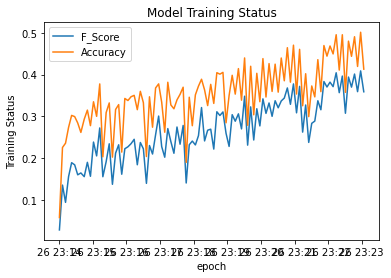

In [16]:
#Create a Chart to visualize the training process 
x = df_training_status[training_status_columns[0]].tolist()

y1 = df_training_status[training_status_columns[1]].tolist()
plt.plot(x, y1, label = "F_Score")
y2 = df_training_status[training_status_columns[2]].tolist()
plt.plot(x, y2, label = "Accuracy")

plt.xlabel('epoch')
plt.ylabel('Training Status')

plt.title('Model Training Status')
plt.legend()
plt.show()

In [17]:
stop here

SyntaxError: invalid syntax (<ipython-input-17-a96ba3aab008>, line 1)

In [ ]:
###########Script pending to be cleaned###########

In [ ]:

df_OPPORTUNITY_DATASET_All_describe

In [ ]:
OPPORTUNITY_DATASET_FILE_LIST_Training
OPPORTUNITY_DATASET_FILE_LIST_Validation
OPPORTUNITY_DATASET_FILE_LIST_Testing





In [ ]:
rr = df_OPPORTUNITY_DATASET_Testing['33 Accelerometer LWR accY'].unique()
for m in rr:
    print(m)

In [ ]:
df_OPPORTUNITY_DATASET_Training.describe()

In [ ]:
df_OPPORTUNITY_DATASET_Testing.describe()

In [ ]:
df_OPPORTUNITY_DATASET_Validation.describe()

In [ ]:
df_OPPORTUNITY_DATASET_Training['file_name'].describe()

In [ ]:
df_OPPORTUNITY_DATASET_All_describe['2 Accelerometer RKN^ accX']['count']
df_OPPORTUNITY_DATASET_All_describe

In [ ]:
df_OPPORTUNITY_DATASET_Training['file_name']

In [ ]:


#len(OPPORTUNITY_column_name_selected)
#df_OPPORTUNITY_DATASET_WIP = df_OPPORTUNITY_DATASET[OPPORTUNITY_column_name_selected]

In [ ]:
OPPORTUNITY_column_name_selected

In [ ]:

df_OPPORTUNITY_DATASET_Validation_WIP

In [ ]:




"""
Training_x, Training_y_1, Training_y_2 = data_generator(df_OPPORTUNITY_DATASET_Training_WIP, SILDE_WINDOW, SILDE_WINDOW_STEP, OPPORTUNITY_column_name_selected)
Training_x = torch.reshape(Training_x, (Training_x.size()[0], 1, Training_x.size()[1], Training_x.size()[2])).float()
"""
"""
Testing_x, Testing_y_1, Testing_y_2 = data_generator(df_OPPORTUNITY_DATASET_Testing_WIP, SILDE_WINDOW, SILDE_WINDOW_STEP, OPPORTUNITY_column_name_selected)
Testing_x = torch.reshape(Testing_x, (Testing_x.size()[0], 1, Testing_x.size()[1], Testing_x.size()[2])).float()

Validation_x, Validation_y_1, Validation_y_2 = data_generator(df_OPPORTUNITY_DATASET_Validation_WIP, SILDE_WINDOW, SILDE_WINDOW_STEP, OPPORTUNITY_column_name_selected)
Validation_x = torch.reshape(Validation_x, (Validation_x.size()[0], 1, Validation_x.size()[1], Validation_x.size()[2])).float()
"""
#def batch_generator():


In [ ]:
#df_OPPORTUNITY_DATASET_Validation_WIP[OPPORTUNITY_column_name_selected[1: -3]][1: 2]

In [ ]:
#df_OPPORTUNITY_DATASET_WIP['22 Accelerometer RKN_ accZ'].unique()

In [ ]:
pd.DataFrame(X_train[0:5000]).to_csv('sdf.csv')

In [ ]:
SILDE_WINDOW = 24
SILDE_WINDOW_STEP = 12


def data_generator(ARRAY_OPPORTUNITY_DATASET_x, ARRAY_OPPORTUNITY_DATASET_y, SILDE_WINDOW, SILDE_WINDOW_STEP):
    row_no_start = 0
    count_index = 0
    while (row_no_start + SILDE_WINDOW - 1) <= len(ARRAY_OPPORTUNITY_DATASET_x):
        count_index += 1
        if count_index % 500 == 0:
            print(count_index)
        row_no_end = row_no_start + SILDE_WINDOW
        df_input = ARRAY_OPPORTUNITY_DATASET_x[row_no_start: row_no_end]
        current_input = torch.tensor([df_input])
        df_output_Locomotion = ARRAY_OPPORTUNITY_DATASET_y[row_no_end - 1]
        df_output_ML_Both_Arms = torch.tensor([df_output_Locomotion])
        current_output_ML_Both_Arms = torch.tensor([df_output_ML_Both_Arms])


        if row_no_start == 0:
            input_tensor = current_input
            output_ML_Both_Arms_tensor = current_output_ML_Both_Arms
        else:
            input_tensor = torch.cat((input_tensor, current_input), 0)
            output_ML_Both_Arms_tensor = torch.cat((output_ML_Both_Arms_tensor, current_output_ML_Both_Arms), 0)
        row_no_start += SILDE_WINDOW_STEP
    return input_tensor, output_ML_Both_Arms_tensor


#X_train_tensor_1, y_train_tensor_1 = data_generator(X_train[0: 40000], y_train[0: 40000], SILDE_WINDOW, SILDE_WINDOW_STEP)


In [ ]:
SILDE_WINDOW = 24
SILDE_WINDOW_STEP = 12


    
    
X_train_tensor, y_train_tensor = data_generator(X_train, y_train, SILDE_WINDOW, SILDE_WINDOW_STEP)

pd.DataFrame(y_train_tensor.numpy()).to_csv('export/' + 'y_target' + '.csv')

df_target = pd.DataFrame(y_train_tensor.numpy())
df_target.columns = ['classification']
class_count = df_target['classification'].value_counts()
class_count = class_count.sort_index(0)
class_count = class_count.tolist()
class_count = 1 / (np.array(class_count) / (sum(class_count) / len(class_count)))
class_count





print(class_count)
#df_target['abc'].nunique()
#df_target
#print(X_train_tensor[0])
#input_tensor.size()
#output_tensor.size()
#print(type(class_count))

#Class_index = list(class_count.index.values)



pd.DataFrame(X_train_tensor[0]).to_csv('0.csv')

pd.DataFrame(y_train).to_csv('y.csv')

Validation_x = X_train_tensor
Validation_x = torch.reshape(Validation_x, (Validation_x.size()[0], 1, Validation_x.size()[1], Validation_x.size()[2])).float()

Validation_y_2 = y_train_tensor


pd.DataFrame(Validation_x[0, 0, :, :]).to_csv('0v.csv')

In [ ]:
y_train_tensor.unique()
X_train_tensor

In [ ]:

y_train_tensor.unique()
#torch.save({'X_train_tensor': X_train_tensor, 'y_train_tensor': y_train_tensor}, 'C:/Users/HX/Magic/training_data.pt')

In [ ]:

np.unique(right_classall_clean_array_y)
#dict_SKODA_class

In [ ]:
"""
data_loading = torch.load("D:/Installation/yolov4.pt")
X_train_tensor = data_loading['X_train_tensor']
y_train_tensor = data_loading['y_train_tensor']
data_loading = ''
"""

In [ ]:
#X_train_tensor.size()

pending items:
    - batch size = 100
    - sensor data were pre-processed to fill in missing values using linear interpolation
    - model accuracy & loss function save into array
    - Dashboard - to show performance
    
    - per channel normalization to interval [0,1]
    https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame

In [ ]:
"""
input = np.array([random() for i in range(24 * 113 * 1 * 6)]).reshape(6, 1, 24, 113)

output = torch.Tensor([[1.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 1.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 1.0, 0.0],
                     [0.0, 0.0, 1.0, 0.0, 0.0],
                     [0.0, 0.0, 1.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 1.0]])


output = torch.Tensor([0, 1, 3, 2, 2, 4])

final_input = torch.Tensor(input)
final_output = torch.Tensor(output)
"""

class CNN_LSTM_HAR_MODEL(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn2d_1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (5, 1))
        #self.conv_bn = nn.BatchNorm2d(64)
        #self.relu = nn.ReLU()
        self.cnn2d_2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (5, 1))
        self.cnn2d_3 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (5, 1))
        self.cnn2d_4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (5, 1))
        
        self.batch_size = 24 - 4 * (5 - 1)
        self.hidden_dim = 128
        self.input_size = 7232
        self.input_size = 1920
        self.n_layers = 2
        
        self.class_no = 11
        
        #self.lstm1 = nn.LSTM(batch_first = True, input_size  = 7232, hidden_size = self.hidden_dim, num_layers = self.n_layers)
        self.lstm1 = nn.LSTM(batch_first = True, input_size  = self.input_size, hidden_size = self.hidden_dim, dropout = 0.5)
        self.lstm2 = nn.LSTM(batch_first = True, input_size  = 128, hidden_size = self.hidden_dim, dropout = 0.5)
        
        #self.lstm1 = nn.LSTM(batch_first = True, input_size  = 7232, hidden_size = self.hidden_dim)
        #self.lstm2 = nn.LSTM(batch_first = True, input_size  = 128, hidden_size = self.hidden_dim)
        
        #self.conv_bn2 = nn.BatchNorm1d(8)
        #, dropout = 0.5
        #self.input_size = 128
        #self.n_layers = 1
        #self.lstm2 = nn.LSTM(input_size  = self.input_size, hidden_size = self.hidden_dim, num_layers = self.n_layers, dropout = 0.5)
        
        #self.fc1 = nn.Linear(128, 18)
        self.fc1 = nn.Linear(128, self.class_no)
        
    def forward(self, x):
        #print(x)
        x = self.cnn2d_1(x)
        #x = self.relu(x)
        #x = self.conv_bn(x)
        #tensor_to_csv(x[0, -1, :, :], 'layer_1_data_0')
        #tensor_to_csv(x[5, -1, :, :], 'layer_1_data_100')
        
        x = self.cnn2d_2(x)
        #x = self.relu(x)
        #x = self.conv_bn(x)
        #tensor_to_csv(x[0, -1, :, :], 'layer_2_data_0')
        #tensor_to_csv(x[5, -1, :, :], 'layer_2_data_100')

        x = self.cnn2d_3(x)
        #x = self.relu(x)
        #x = self.conv_bn(x)
        #tensor_to_csv(x[0, -1, :, :], 'layer_3_data_0')
        #tensor_to_csv(x[5, -1, :, :], 'layer_3_data_100')

        x = self.cnn2d_4(x)
        #x = self.relu(x)
        #x = self.conv_bn(x)
        #tensor_to_csv(x[0, -1, :, :], 'layer_4_data_0')
        #tensor_to_csv(x[5, -1, :, :], 'layer_4_data_100')

        #print(x.size())
        x = torch.transpose(x, 1, 2)
        #print(x.size())
        x = torch.reshape(x, (x.size()[0], x.size()[1], -1))

        #hidden = self.init_hidden()
        #hidden = (torch.randn(2, x.size()[0], self.hidden_dim).cuda(), torch.randn(2, x.size()[0], self.hidden_dim).cuda())
        #x, hidden = self.lstm1(x, hidden)
        x, hidden = self.lstm1(x)
        x, hidden = self.lstm2(x)
        #print(x)
        #x = self.conv_bn2(x)
        #hidden = self.conv_bn2(hidden)
        #tensor_to_csv(x[0, -1, :,], 'layer_lstm1_data_0')
        #tensor_to_csv(x[5, -1, :], 'layer_lstm1_data_100')
        #print(x)
        #hidden2 = (torch.zeros(self.n_layers, 8, self.hidden_dim).requires_grad_(), torch.zeros(self.n_layers, 8, self.hidden_dim).requires_grad_())
        ###############################
        #x, hidden = self.lstm2(x, hidden)
        #print(x)
        #x = self.conv_bn2(x)
        
        #tensor_to_csv(x[0, -1, :,], 'layer_lstm2_data_0')
        #tensor_to_csv(x[15, -1, :], 'layer_lstm2_data_100')
        #print(x.size())
        x = torch.reshape(x, (-1, 128))
        #print(x.size())
        
        x = self.fc1(x)
        x = F.softmax(x, dim = 1)
        #x = F.softmax(x)
        x = torch.reshape(x, (int(x.size()[0] / 8), 8, self.class_no))
        x = x[:, -1, :]
        #print(x.size())
        tensor_to_csv(x, 'layer_fc1_data')
        
        
        tensor_to_csv(x, 'output_data')
        
        
        #print(x)
        return x
    
    def init_hidden(self):
        weight = next(self.parameters()).data

        hidden = (weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_())
        return hidden

    
    
    
    
    




In [ ]:
#list(Validation_y_2.size())[0]

In [ ]:
def tensor_to_csv(tensor_name):
    x_np = tensor_name.numpy()
    x_df = pd.DataFrame(x_np)
    x_df.to_csv('tmp.csv')

Validation_x.size()
#output

tensor_to_csv(output.detach())


#Validation_x_to_csv = torch.reshape(Validation_x, (Validation_x.size()[0] * Validation_x.size()[1] * Validation_x.size()[2], Validation_x.size()[3])).float()
#tensor_to_csv(Validation_x_to_csv.detach())
#tensor_to_csv(Validation_x[1, 0,:, :])

#tensor_to_csv(Validation_y_2)

for row_no_end in range(0, 155):
    print(row_no_end)
    print(df_OPPORTUNITY_DATASET_Validation_WIP['250 ML_Both_Arms'][row_no_end])

In [ ]:
input.size()
target
CNN_LSTM_HAR_MODEL_WIP.parameters()
target
Validation_y_2.sum()
print(Validation_y_2)
for i in Validation_y_2.long():
    print(i)

In [ ]:
for i in CNN_LSTM_HAR_MODEL_WIP.parameters():
    print(i.size())
    print(i)

In [ ]:

torch.isnan(Validation_x)



x_np = Validation_x[0, 0,:, :].numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('tmp.csv')





In [ ]:
>>> rnn = nn.LSTM(10, 20, 2)
>>> input = torch.randn(5, 3, 10)
>>> h0 = torch.randn(2, 3, 20)
>>> c0 = torch.randn(2, 3, 20)
>>> output, (hn, cn) = rnn(input, (h0, c0))

output.size()
#hn.size()

In [ ]:
kk = torch.tensor([[[k* 100 + j * 10 + i for i in range (10)] for j in range(10)] for k in range(10)])
kk
#mm = torch.reshape(kk, (kk.size()[0], 1, kk.size()[1], kk.size()[2])).float()
mm = torch.reshape(kk, (kk.size()[0], -1))


print(mm.size())

print(mm[0])


"""
mm[:, 0, :, :] == kk
mm[5, 0, 4, 3]
"""

In [ ]:
for para in CNN_LSTM_HAR_MODEL_WIP.parameters():
    print(para.size())

In [ ]:
df_OPPORTUNITY_DATASET_Training_WIP[OPPORTUNITY_column_name_selected][0:2000].to_csv('def.csv')

In [ ]:
0.2/0.8/17


In [ ]:
for i in CNN_LSTM_HAR_MODEL_WIP.parameters():
    print(i.size())
    #print(i)
    
    